In [1]:
# ensemble modeller

# import various evidence layers
# build frame of discernment
# e.g. rescale images > 0.8 for each image
# which images are gdv areas, which layers are non-gdv areas?

# superset = [L, P, S, F, C]

# L = GDV Likelihood
# P = Phenometric (e.g. LIOT)
# S = SDM
# F = Fractional Map
# C = CHM

# determine if each layer is site, non-site.
# assign bpa's 
# e.g. bird like sw aspect, so sw aspect gets 0.75, flat givem 0.5, rest (superset) gets 0.25
# e.g. increasing signmoidal, 0 to 1
# combine site hypotheses (e.g. site layers)
# e.g. site (vege layer) = 0.8, rest (ignoreance) get 0.2. 
# e.g. site (aspect) =0.9, rest (ignoreance) get 0.1
# prepare matrix for site hypothesies (vege, aspect)
# cross multiply sites (veg x aspect) and ignorance
# next matrix for non-sites 1, 2, cross multi,sum values
# new matrix for non-sites 2, 3, cross multi,sum values
# add results of those two into matrix, cross multi, then sum values
# take result from site, non-site, superset, and put in new matrix
# cross multi, sum up, divide by intersection 
# calc belief by summing any site values, calc disbelief by summing any non-site
# do this per pixel
# you get disbelief, plaus, belief interval (plaus - belief) and belief


# Ensemble

## Initialise Ensemble

### Load packages

In [4]:
%matplotlib inline
%load_ext autoreload

import os, sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import datacube
sys.path.append('../../../Scripts')
from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('../../modules')
import gdvspectra, phenolopy, nicher, vegfrax, canopy

sys.path.append('../../shared')
import satfetcher, tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up a dask cluster and ODC

In [5]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

# open up a datacube connection
dc = datacube.Datacube(app='ensemble')

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37473 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:44823 Dashboard: /user/lewis/proxy/37473/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Study area and data setup

### Set study area, time range, show map

In [6]:
# testing study area extent - yandi and roy hill
#lat_extent, lon_extent = (-22.82901, -22.67901), (118.94980, 119.29979)  # yandi
lat_extent, lon_extent = (-22.63461, -22.33461), (119.88111, 120.18111) # royhill

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

# Generate GDV Likelihood

### Load and prepare DEA ODC satellite data

In [5]:
# provide study area name
study_area = 'royhill'

# select start and end year range
time_range = ('2016', '2020')

# set datacube query parameters
platform = 'landsat'
bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
#bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2'] # sentinel
min_gooddata = 0.90

# fetch satellite data from dea ard product
ds = satfetcher.load_dea_ard(platform=platform, 
                             bands=bands, 
                             x_extent=lon_extent, 
                             y_extent=lat_extent, 
                             time_range=time_range, 
                             min_gooddata=min_gooddata, 
                             use_dask=True)

# rename dea bands to common standard
ds = satfetcher.conform_dea_ard_band_names(ds=ds, platform=platform)

# take a copy of dataset for cva later
ds_backup = ds.copy(deep=True)

# display dataset
#ds

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,
/home/jovyan/tenement-tools/notebooks/ensemble/../../../Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Loading DEA ODC ARD satellite data.
Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 83 out of 227 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 83 time steps as a dask array
Satellite imagery fetched successfully.
Conforming DEA ARD satellite band names.
Satellite band names conformed successfully.


### Calculate standardised vege/moist data

In [ ]:
# set wet and dry season month(s). we will use several per season
wet_month, dry_month = [1, 2, 3], [9, 10, 11]

# get subset fo data for wet and dry season months
ds = gdvspectra.subset_months(ds=ds, 
                              month=wet_month + dry_month,
                              inplace=True)

# calculate veg (mavi) and moist (ndmi) indices
ds = tools.calculate_indices(ds=ds, 
                             index=['mavi', 'ndmi'], 
                             custom_name=['veg_idx', 'mst_idx'], 
                             rescale=True, 
                             drop=True)

# perform resampling
ds = gdvspectra.resample_to_wet_dry_medians(ds=ds, 
                                            wet_month=wet_month, 
                                            dry_month=dry_month,
                                            inplace=True)

# we have some calcs to make, persist now
ds = ds.persist()

# drop any years from dataset where wet and dry seasons missing
ds = gdvspectra.drop_incomplete_wet_dry_years(ds)

# todo - remove this compute when bug fixed in ver > 0.18.2
ds = ds.compute()

# fill any empty first, last years using back/forward fill
ds = gdvspectra.fill_empty_wet_dry_edges(ds=ds,
                                         wet_month=wet_month, 
                                         dry_month=dry_month,
                                         inplace=True)

# interpolate all missing pixels using full linear interpolation
ds =  gdvspectra.interp_empty_wet_dry(ds=ds,
                                      wet_month=wet_month, 
                                      dry_month=dry_month,
                                      method='full', 
                                      inplace=True)

# standardise data to invariant targets derived from dry times
ds = gdvspectra.standardise_to_dry_targets(ds=ds, 
                                           dry_month=dry_month, 
                                           q_upper=0.99, 
                                           q_lower=0.05,
                                           inplace=True)

# calculate standardised seaonal similarity (diff between wet, dry per year)
ds_similarity = gdvspectra.calc_seasonal_similarity(ds=ds,
                                                    wet_month=wet_month,
                                                    dry_month=dry_month,
                                                    q_mask=0.9,
                                                    inplace=True)

### Generate likelihood model

In [ ]:
# generate gdv likelihood model using wet, dry, similarity variables
ds_like = gdvspectra.calc_likelihood(ds=ds, 
                                     ds_similarity=ds_similarity,
                                     wet_month=wet_month, 
                                     dry_month=dry_month)

# preview an all-time median of gdv likelihood. red is high likelihood
fig = plt.figure(figsize=(10, 5))
ds_like['like'].median('time').plot(robust=False, cmap='jet')

# create out file
out_like_nc = '../../{0}_{1}_{2}_{3}_like.nc'.format(study_area,
                                                     time_range[0],
                                                     time_range[1],
                                                     platform)

### Generate field occurrence points for thresholding

In [ ]:
# set location of point shapefile with presence/absence column
#shp_path = r'../GDVSDM/data_testing/presence_points/presence_points.shp'
shp_path = r'../../data/gdvspectra/royhill_2_final_albers.shp'

# read shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset to just x, y, pres/abse column
df_records = tools.subset_records(df_records=df_records, p_a_column='GDV_ACT')

# display dataframe
#df_records

### Threshold likelihood

In [ ]:
# perform thresholding using standard deviation on all-time median likelihood
ds_thresh = gdvspectra.threshold_likelihood(ds=ds_like.median('time', keep_attrs=True),
                                            df=df_records, 
                                            num_stdevs=2.5, 
                                            res_factor=3, 
                                            if_nodata='any')

# preview an all-time median of gdv likelihood thresholded
fig = plt.figure(figsize=(10, 5))
ds_thresh.where(~ds_thresh.isnull(), 0.001)['like'].plot(robust=False, cmap='jet')

### Export GDV likelihood and threshold for later

In [ ]:
# export median likelihood to nc
#tools.export_xr_as_nc(ds=ds_like['like'].median('time'), filename='ds_like.nc')

# export threshold as nc
#tools.export_xr_as_nc(ds_thresh, filename='ds_threshold.nc')

### Calculate trends using Mann-Kendall trend analysis

In [ ]:
# create a mask where gdv highly likely
ds_mask = xr.where(~ds_thresh.isnull(), True, False)

# do mk to find sig. inc/dec trends in high likelihood areas
ds_mk = gdvspectra.perform_mk_original(ds=ds_like.where(ds_mask), 
                                       pvalue=None, 
                                       direction='both')

# show mk trends. blue is increasing, red is decreasing
fig = plt.figure(figsize=(10, 5))
ds_mk['tau'].plot(robust=True, cmap='Spectral')

### Calculate slope using Theil-Sen

In [ ]:
# create a mask where gdv highly likely
ds_mask = xr.where(~ds_thresh.isnull(), True, False)

# do theil sen slopes in high likelihood areas
ds_ts = gdvspectra.perform_theilsen_slope(ds=ds_like.where(ds_mask), 
                                          alpha=0.95)

# show mk trends. blue is increasing, red is decreasing
fig = plt.figure(figsize=(10, 5))
ds_ts['theilsen'].plot(robust=True, cmap='Spectral')

# Generate Phenometrics

### Calculate and pre-process vegetation

In [ ]:
# takes our dask ds and calculates veg index from spectral bands
ds = tools.calculate_indices(ds=ds_backup, 
                             index='mavi', 
                             custom_name='veg_idx', 
                             rescale=False, 
                             drop=True)

# conform edges
ds = phenolopy.conform_edge_dates(ds=ds)

# resample to weekly medians
ds = phenolopy.resample(ds=ds, 
                        interval='1W',
                        inplace=True)

# interpolate missing values
ds = phenolopy.interpolate(ds=ds, 
                           method='full', 
                           inplace=True)

# group into single year of weekly all-time medians
ds = phenolopy.group(ds=ds, 
                     interval='week',
                     inplace=True)

# takes our dask ds and remove outliers from data using median method
ds = phenolopy.remove_outliers(ds=ds, 
                               method='median', 
                               user_factor=2, 
                               z_pval=0.05)

# take dataset and resample data to weekly medians (1WS)
ds = phenolopy.resample(ds=ds, 
                        interval='1W',
                        inplace=True)

# remove any years outside of dominant year
ds = phenolopy.remove_overshoot_times(ds=ds, max_times=3)

# use savitsky-golay filter to smooth across time dimension
ds = phenolopy.smooth(ds=ds, 
                      method='savitsky', 
                      window_length=3, 
                      polyorder=1, 
                      sigma=1)

### Calculate phenometrics

In [ ]:
# compute into memory
ds = ds.compute()

# set desired metrics
#metrics = ['sos', 'eos', 'lios', 'sios', 'liot', 'siot']

# calc phenometrics via phenolopy!
ds = phenolopy.calc_phenometrics(ds=ds,
                                 peak_metric='pos', 
                                 base_metric='vos', 
                                 method='seasonal_amplitude', 
                                 factor=0.2, 
                                 thresh_sides='one_sided', 
                                 abs_value=0.1)

### Display phenometric

In [ ]:
# set the metric to display
metric_name = 'liot_values'
fig = plt.figure(figsize=(9, 7), dpi=85)
ds[metric_name].plot(robust=True, cmap='terrain_r')

### Generate field occurrence points for thresholding

In [ ]:
# set location of point shapefile with presence/absence column
#shp_path = r'../GDVSDM/data_testing/presence_points/presence_points.shp'
shp_path = r'../../data/gdvspectra/royhill_2_final_albers.shp'

# read shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset to just x, y, pres/abse column
df_records = tools.subset_records(df_records=df_records, p_a_column='GDV_ACT')

# display dataframe
#df_records

### Check AUC of metrics

In [ ]:
# prepare metric for auc
metric = 'vos_values'
da = ds[metric].rename({'variable': 'time'}).to_dataset(promote_attrs=True)
da = da.rename({metric: 'like'})

# threshold to get auc
gdvspectra.threshold_likelihood(ds=da,
                                df=df_records, 
                                num_stdevs=2.5, 
                                res_factor=3, 
                                if_nodata='any')

In [ ]:
# export to nc
#tools.export_xr_as_nc(ds=ds, filename='ds_phenometrics.nc')

# Generate Species Distribution Model

### Set up data

Found: dem_lidar_10m_solar_rad.tif
Found: dem_lidar_10m_flow_acumm.tif
Found: dem_lidar_10m_aspect.tif
Found: dem_lidar_10m.tif
Found: dem_lidar_10m_tri.tif
Found: dem_lidar_10m_valley_depth.tif
Found: dem_lidar_10m_lsfactor.tif
Found: dem_lidar_10m_convexity.tif
Found: dem_lidar_10m_saga_wetness.tif
Found: dem_lidar_10m_mrvbf.tif
Found: chm_lidar_10m.tif
Found: dem_lidar_10m_fill.tif
Found: dem_lidar_10m_mrrtf.tif
Found: dem_lidar_10m_texture.tif
Found: dem_lidar_10m_slope.tif
Found: dem_lidar_10m_tpi.tif
Found: dem_lidar_10m_curvature.tif
Found: dem_lidar_10m_topo_wetness.tif
Converting rasters to an xarray dataset.
Converted raster to xarray data array: dem_lidar_10m_solar_rad
Converted raster to xarray data array: dem_lidar_10m_flow_acumm
Converted raster to xarray data array: dem_lidar_10m_aspect
Converted raster to xarray data array: dem_lidar_10m_valley_depth
Converted raster to xarray data array: dem_lidar_10m_lsfactor
Converted raster to xarray data array: dem_lidar_10m_convex

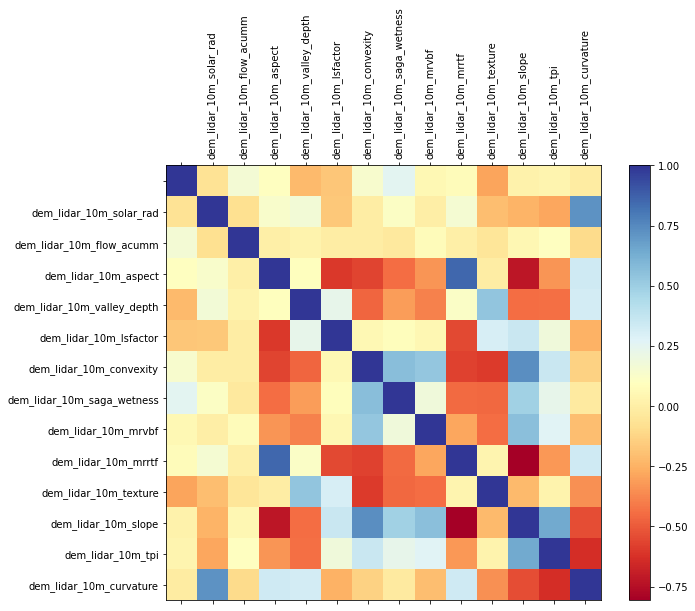



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
                      Variable  VIF Score
2         dem_lidar_10m_aspect      1.047
0      dem_lidar_10m_solar_rad      1.225
8          dem_lidar_10m_mrrtf      1.497
7          dem_lidar_10m_mrvbf      1.707
5      dem_lidar_10m_convexity      1.879
12     dem_lidar_10m_curvature      2.153
4       dem_lidar_10m_lsfactor      2.247
13  dem_lidar_10m_topo_wetness      2.536
3   dem_lidar_10m_valley_depth      2.774
1     dem_lidar_10m_flow_acumm      3.144
6   dem_lidar_10m_saga_wetness      3.572
9        dem_lidar_10m_texture      4.082
10         dem_lidar_10m_slope      4.613
11           dem_lidar_10m_tpi      5.335
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

Creating species distribution model estimator.
Setting up estimator for Random Forest.
Estimator created successfully.
Beginning species distribution modelling (SDM) process.
Generating SDM replicate: 1 of 5.
Generating SDM replicate: 2 of 5.
Ge

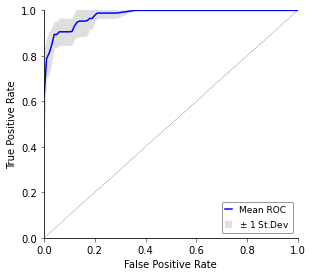

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training Out-Of-Bag (OOB) Accuracy:		1.0
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - Probabilities Accuracy Metrics  - - - - - - - - - - - - 
Area Under the ROC Curve (AUC).
Terrible = 0.5 | Moderate = 0.75 | Perfect = 1.0
AUC: 0.976

Area Under the Precision Recall Curve (PR Score).
Terrible = 0.0 | Perfect = 1.0.
PR Score: 0.904

Brier Loss Score.
Terrible: 1.0 | Perfect: 0.0 (lower score is better).
Brier Loss Score: 0.041

Log-Loss Score (stricter than Brier Loss Score).
Perfect: 0.0 (lower score is better).
Log-Loss Score: 0.143

Point-biserial Correlation Coefficient (R-value).
Perfect + relationship = 1 | Perfect - relationship = -1 | No relationship = 0. 
R-value: 0.824
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - Classification Accuracy Metrics - - - - - - - - - - - - 
Proportion of presence records: 0.021
Proport

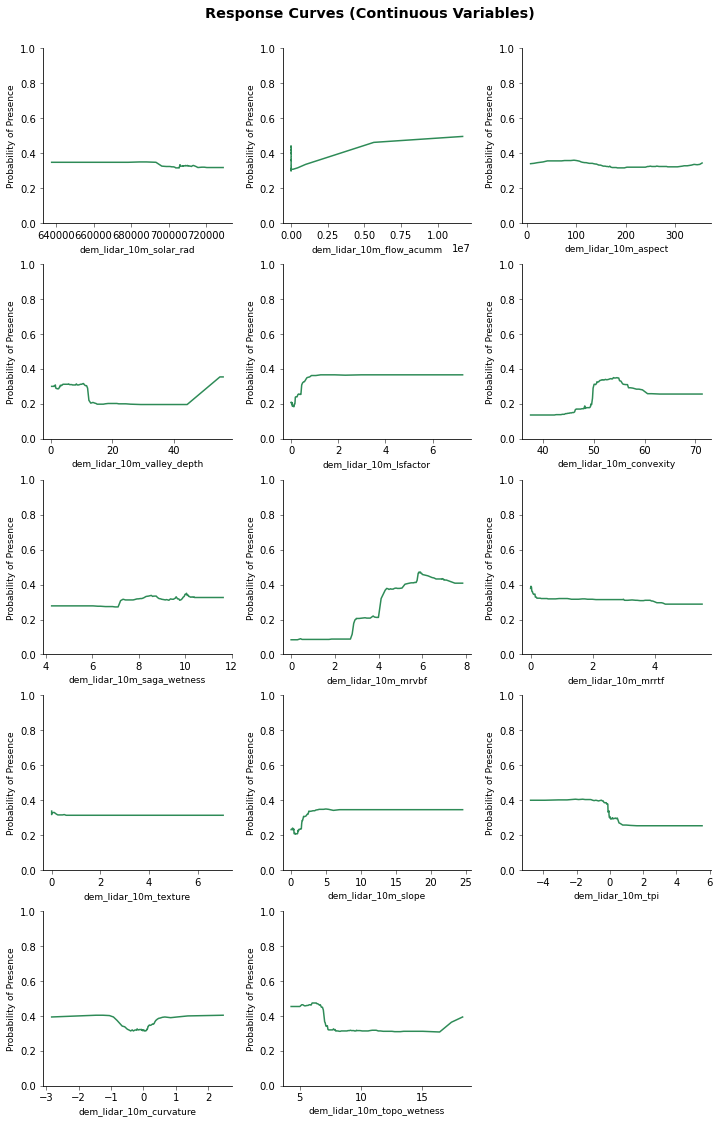

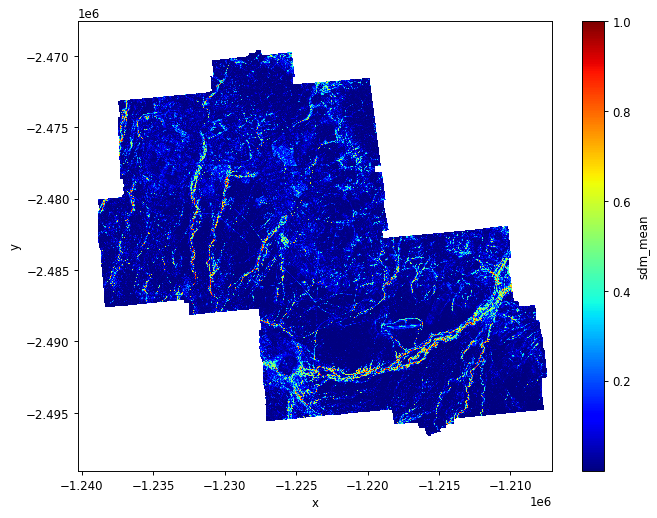

In [5]:
# get continuous rasters. wwe will use lidar
folder_path = r'../../data/nicher/roy_lidar'
rast_cont_list = nicher.get_files_from_path(folder_path)

# drop any undesirable vars 
rast_cont_list.remove(folder_path + '/' + 'chm_lidar_10m.tif')
rast_cont_list.remove(folder_path + '/' + 'dem_lidar_10m_fill.tif')
rast_cont_list.remove(folder_path + '/' + 'dem_lidar_10m.tif')
rast_cont_list.remove(folder_path + '/' + 'dem_lidar_10m_tri.tif')

# load rasters as individual dataset variables
ds_sdm = satfetcher.load_local_rasters(rast_path_list=rast_cont_list, 
                                       use_dask=True, 
                                       conform_nodata_to=-999)

# compute dask - we need to make calculations
ds_sdm = ds_sdm.compute()

# set path to shapefile
shp_path = r'../../data/nicher/presence_points/presence_points.shp'

# extract point x and y from shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset columns
df_presence = tools.subset_records(df_records=df_records, 
                                   p_a_column=None)

# drop presence column
df_presence = df_presence.drop('actual', axis='columns')

# generate absences using dataset pixels and occurrence coords
df_absence = nicher.generate_absences(ds=ds_sdm, 
                                      occur_shp_path=shp_path,
                                      buff_m=250, 
                                      res_factor=3)

# extract values for presence points
df_presence_data = tools.extract_xr_values(ds=ds_sdm, 
                                           coords=df_presence, 
                                           keep_xy=False, 
                                           res_factor=3)

# do same for absence points
df_absence_data = tools.extract_xr_values(ds=ds_sdm, 
                                          coords=df_absence, 
                                          keep_xy=False, 
                                          res_factor=3)

# remove all presence records containing nodata values
df_presence_data = tools.remove_nodata_records(df_records=df_presence_data,
                                               nodata_value=ds_sdm.nodatavals)

# remove all absence records containing nodata values
df_absence_data = tools.remove_nodata_records(df_records=df_absence_data,
                                               nodata_value=ds_sdm.nodatavals)

# take pres and abse records and combine, add new pres/abse column
df_pres_abse_data = nicher.combine_pres_abse_records(df_presence=df_presence_data, 
                                                     df_absence=df_absence_data)

# generate the matrix. < 0.6 weak collinearity, 0.6-0.8 moderate, >= 0.8 strong
nicher.generate_correlation_matrix(df_records=df_pres_abse_data,
                                   show_fig=True,
                                   show_text=False)

# generate vif scores. 1 = No multicolinearity, 1-5 = moderate, > 5 = high, > 10 = Remove
nicher.generate_vif_scores(df_records=df_pres_abse_data)
plt.show()

# create a random forest estimator using default sklearn parameters
estimator = nicher.create_estimator(estimator_type='rf', 
                                    n_estimators=100)

# generate SDM with 5 replicates and 10% training-testing split
ds_sdm = nicher.generate_sdm(ds=ds_sdm, 
                             df_records=df_pres_abse_data, 
                             estimator=estimator, 
                             rast_cont_list=rast_cont_list, 
                             rast_cate_list=None, 
                             replicates=5, 
                             test_ratio=0.1, 
                             equalise_test_set=False, 
                             calc_accuracy_stats=True)

# show results
fig = plt.figure(figsize=(9, 7), dpi=85)
ds_sdm['sdm_mean'].plot(robust=False, cmap='jet')

In [ ]:
# export to nc
#tools.export_xr_as_nc(ds=ds_sdm, filename='ds_sdm.nc')

# Generate Veg Frax

### Prepare Landsat satellite image

In [6]:
# calculate veg (mavi) and moist (ndmi) indices
ds_raw = tools.calculate_indices(ds=ds_backup, 
                                 index=['tcg', 'tcb', 'tcw'], 
                                 custom_name=None, 
                                 rescale=False, 
                                 drop=True)

# load into memory now - we have values to modify!
ds_raw = ds_raw.median('time', keep_attrs=True).compute()

Calculating indices: ['tcg', 'tcb', 'tcw'].
Calculating index: tcg
Calculating index: tcb
Calculating index: tcw
Calculated indices successfully.


### Prepare classified hi-def raster

In [7]:
# set path to high-resolution classified image (e.g. 10m Sentinel 2 or 1m WV)
rast_class = r'../../data/vegfrax/class/Vegetation_Mapping_Mine_20181121_rasterised_albers.tif'
ds_class = satfetcher.load_local_rasters(rast_path_list=[rast_class], 
                                         use_dask=True, 
                                         conform_nodata_to=-128)

# do basic preparations (dtype, rename, checks)
ds_class = vegfrax.prepare_classified_xr(ds=ds_class)

# subset high to low extent
ds_class = tools.clip_xr_to_xr(ds_a=ds_class, 
                               ds_b=ds_raw)

# set them manually (make sure you include 0 if reclassifying)
req_class = [1, 3, 13, 14, 0]
ds_class = vegfrax.reclassify_xr(ds=ds_class, 
                                 req_class=req_class,
                                 merge_classes=True,
                                 inplace=True)

# get list of all classes...
req_class = vegfrax.get_xr_classes(ds_class)

# load into memory now - we have values to modify!
ds_class = ds_class.compute()

Converting rasters to an xarray dataset.
Converted raster to xarray data array: Vegetation_Mapping_Mine_20181121_rasterised_albers
Extracting CRS from dataset.
CRS extracted successfully from dataset.
Rasters converted to dataset successfully.

Preparing classified dataset.
Prepared classified dataset successfully.
Clipping dataset to another.
Extracting spatial extent from dataset.
Clipped dataset successfully.
Reclassifying classes.
Reclassified dataset successfully.
Getting unique classes from dataset.
Detected classes in dataset: 0, 1


### Prepare frequencies

In [8]:
# generate random samples within area overlap between raw and classified rasters
num_samples = 500
df_samples = vegfrax.generate_strat_random_samples(ds_raw=ds_raw,
                                                   ds_class=ds_class, 
                                                   req_class=req_class,
                                                   num_samples=num_samples)

# extract pixel values from raw, low resolution rasters at each point
df_extract = tools.extract_xr_values(ds=ds_raw, 
                                     coords=df_samples, 
                                     keep_xy=True)

# remove any points containing a nodata value
df_extract_clean = tools.remove_nodata_records(df_extract, 
                                               nodata_value=ds_raw.nodatavals)

# generate focal windows and extract pixels from class raster
df_windows = vegfrax.create_frequency_windows(ds_raw=ds_raw, 
                                              ds_class=ds_class, 
                                              df_records=df_extract_clean)

# transform raw focal window pixel classes and counts to unique classes and frequencies at each point
df_freqs = vegfrax.convert_window_counts_to_freqs(df_windows=df_windows, 
                                                  nodata_value=ds_class.nodatavals)

Generating 500 stratified randomised sample points.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracting spatial extent from dataset.
Extracting spatial extent from dataset.
Generating stratified random points.
Preparing samples for class: 0


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Preparing samples for class: 1
Generated stratified random sample points successfully.
Extracting xarray dataset values to x and y coordinates.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracted xarray dataset values successfully.
Removing records containing NoData (nan) values.
Removed 0 records containing NoData values successfully.
Creating frequency focal windows from random sample points.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Computing windows into memory, this can take awhile. Please wait.
1000 windows generated successfully.
Generating class frequencies from window pixels.
Checking for empty rows and dropping if exist.
1000 windows transformed to frequencies successfully.


### Perform FCA

Converting dataset to sklearn analysis-ready format.
Converting classes and frequencies into analysis-ready format.
Normalising rows with regards to subset classes and NoData values.
Creating NoData mask.
Data successfully prepared for analysis.
Beginning fractional cover analysis (FCA).
Fitting and predicting model for class: 1
Mean OOB: 0.54. Mean MAE: 0.21. Mean RMSE: 0.31. Mean R-squared: 0.57. Best R-squared: 0.65
Fractional cover analysis (FCA) completed successfully.


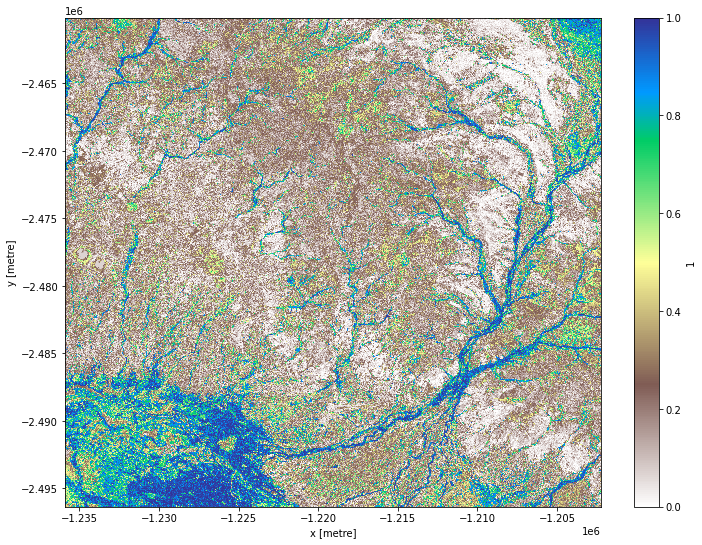

In [9]:
# set desired output classes. keep empty to produce all classes. could put 1, 2 for classes 1 and 2.
override_classes = ['1']

# prepare data for analysis - prepare classes, nulls, normalise frequencies
df_data = vegfrax.prepare_freqs_for_analysis(ds_raw=ds_raw, 
                                             ds_class=ds_class, 
                                             df_freqs=df_freqs, 
                                             override_classes=override_classes)

# perform fca
ds_preds = vegfrax.perform_fca(ds_raw=ds_raw, 
                               ds_class=ds_class, 
                               df_data=df_data, 
                               df_extract_clean=df_extract_clean, 
                               n_estimators=100,
                               n_validations=10)

# create fig
class_label = '1'
fig = plt.figure(figsize=(12, 9))
ds_preds[class_label].plot(robust=False, cmap='terrain_r')

### Generate field occurrence points for thresholding

In [10]:
# set location of point shapefile with presence/absence column
#shp_path = r'../GDVSDM/data_testing/presence_points/presence_points.shp'
shp_path = r'../../data/gdvspectra/royhill_2_final_albers.shp'

# read shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset to just x, y, pres/abse column
df_records = tools.subset_records(df_records=df_records, p_a_column='GDV_ACT')

# display dataframe
#df_records

Reading records within shapefile.
Rows read from shapefile successfully.
Subsetting records from dataframe.
Subset records successfully.


In [11]:
# prepare metric for auc
ds_preds.attrs = ds.attrs
da = ds_preds.rename({class_label: 'like'})

# threshold to get auc
gdvspectra.threshold_likelihood(ds=da,
                                df=df_records, 
                                num_stdevs=2.5, 
                                res_factor=3, 
                                if_nodata='any')

Thresholding groundwater-dependent vegeation likelihood.
Thresholding dataset via occurrence records and AUC.
Clipping pandas dataframe records to xarray dataset.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracted xarray dataset values successfully.
Removing records containing NoData (nan) values.
Removed 0 records containing NoData values successfully.
AUC: 0.714 for whole dataset.
Thresholded dataset successfully.
Thresholded likelihood succuessfully.


<xarray.Dataset>
Dimensions:  (x: 1121, y: 1208)
Coordinates:
  * x        (x) float64 -1.236e+06 -1.236e+06 ... -1.202e+06 -1.202e+06
  * y        (y) float64 -2.46e+06 -2.46e+06 -2.46e+06 ... -2.496e+06 -2.496e+06
Data variables:
    like     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref
    nodatavals:    nan

## Perform Ensemble

In [27]:
# load like var
ds_like = satfetcher.load_local_rasters(rast_path_list=r'../../data/ensemble/royhill/like.tif', 
                                        use_dask=True, 
                                        conform_nodata_to=np.nan)

# load liot var
ds_liot = satfetcher.load_local_rasters(rast_path_list=r'../../data/ensemble/royhill/pheno_liot.tif', 
                                        use_dask=True, 
                                        conform_nodata_to=np.nan)

# load sdm lidar
ds_sdm = satfetcher.load_local_rasters(rast_path_list=r'../../data/ensemble/royhill/sdm_lidar.tif', 
                                       use_dask=True, 
                                       conform_nodata_to=np.nan)

# load veg frax
ds_frax = satfetcher.load_local_rasters(rast_path_list=r'../../data/ensemble/royhill/vegfrax_class_3_vs_0.tif', 
                                        use_dask=True, 
                                        conform_nodata_to=np.nan)

# load chm
ds_chm = satfetcher.load_local_rasters(rast_path_list=r'../../data/ensemble/royhill/chm_lidar_10m.tif', 
                                        use_dask=True, 
                                        conform_nodata_to=np.nan)

Converting rasters to an xarray dataset.
Converted raster to xarray data array: like
Rasters converted to dataset successfully.

Converting rasters to an xarray dataset.
Converted raster to xarray data array: pheno_liot
Rasters converted to dataset successfully.

Converting rasters to an xarray dataset.
Converted raster to xarray data array: sdm_lidar
Rasters converted to dataset successfully.

Converting rasters to an xarray dataset.
Converted raster to xarray data array: vegfrax_class_3_vs_0
Rasters converted to dataset successfully.

Converting rasters to an xarray dataset.
Converted raster to xarray data array: chm_lidar_10m
Rasters converted to dataset successfully.



In [24]:
# resample higher to lower
sdm to like
